<a href="https://colab.research.google.com/github/saltfry/21Projects21Days/blob/main/9_Advanced_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Pre-trained Models on CIFAR-100

## Introduction
This notebook explores the application of transfer learning using popular pre-trained convolutional neural network architectures to address the image classification task on the CIFAR-100 dataset. Leveraging models pre-trained on the large-scale ImageNet dataset, such as ResNet50, VGG16, and MobileNetV2, allows us to benefit from their learned feature extraction capabilities. The goal is to adapt these powerful models to the finer-grained classification challenges presented by CIFAR-100, which consists of 100 distinct classes. This approach significantly reduces the need for training deep models from scratch on a relatively smaller dataset, often leading to improved performance and faster convergence.

## Project Flow

1.  **Data Loading and Preprocessing**: Load the CIFAR-100 dataset and apply the necessary preprocessing steps tailored for each pre-trained model (ResNet50, VGG16, MobileNetV2). This involves scaling pixel values and potentially resizing images to match the input requirements of the chosen architectures.

2.  **Model Preparation**:
    *   Load pre-trained models (ResNet50, VGG16, MobileNetV2) without their top classification layers.
    *   Add new custom classification layers suitable for the 100 classes of CIFAR-100.
    *   Freeze the layers of the pre-trained base models to retain the learned features during initial training.
    *   Compile the models with an appropriate optimizer, loss function, and metrics.

3.  **Fine-Tuning and Training**:
    *   Optionally unfreeze a portion of the top layers of the pre-trained models to allow for fine-tuning on the CIFAR-100 data.
    *   Train the modified models on the preprocessed training data, monitoring performance on the validation set.

4.  **Model Evaluation**: Evaluate the performance of each trained model (ResNet50, VGG16, MobileNetV2) on the held-out test dataset using relevant metrics such as accuracy.

5. **Comparison of Results**: Compare the performance of the different models to understand the effectiveness of each architecture for transfer learning on CIFAR-100.

## 1. Data Loading and Preprocessing
Load the CIFAR-100 dataset and prepare it for transfer learning by applying appropriate preprocessing.

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100

from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2


(X_train, y_train), (X_test, y_test) = cifar100.load_data()

X_train_resnet50 = preprocess_resnet50(X_train)
X_test_resnet50  = preprocess_resnet50(X_test)

X_train_vgg16 = preprocess_vgg16(X_train)
X_test_vgg16  = preprocess_vgg16(X_test)

X_train_mobilenetv2 = preprocess_mobilenetv2(X_train)
X_test_mobilenetv2  = preprocess_mobilenetv2(X_test)

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


## 2. Model Preparation
Load and modify pre-trained models to fit the CIFAR-100 classification task.

### 2.1 Using ResNet50

In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained ResNet50 model without the top layer
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

x = GlobalAveragePooling2D()(base_model_resnet50.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(100, activation='softmax')(x) # output layer

model_resnet50 = Model(inputs=base_model_resnet50.input, outputs=predictions)

model_resnet50.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


### 2.2 Using VGG16

In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained VGG16 model without the top layer
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
# Add new layers
x = GlobalAveragePooling2D()(base_model_vgg16.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(100, activation='softmax')(x)
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions)

model_vgg16.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


### 2.3 Using MobileNetV2

In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained MobileNetV2 model without the top layer
base_model_mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
# Add new layers
x = GlobalAveragePooling2D()(base_model_mobilenetv2.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(100, activation='softmax')(x)
model_mobilenetv2 = Model(inputs=base_model_mobilenetv2.input, outputs=predictions)

model_mobilenetv2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/tmp/ipython-input-3794676327.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## 3. Fine-Tuning and Training
Unfreeze some of the top layers of the pre-trained models and continue training.

In [5]:
epochs = 3

print(len(model_resnet50.layers))
print(len(model_vgg16.layers))
print(len(model_mobilenetv2.layers))


# Fine-tuning ResNet50
for layer in model_resnet50.layers[:-30]:
    layer.trainable = False

for layer in model_resnet50.layers[-30:]:
    layer.trainable = True

history_resnet50 = model_resnet50.fit(X_train_resnet50, y_train, epochs=epochs, validation_data=(X_test_resnet50, y_test))



# Fine-tuning VGG16
for layer in model_vgg16.layers[:-5]:
    layer.trainable = False

for layer in model_vgg16.layers[-5:]:
    layer.trainable = True

history_vgg16 = model_vgg16.fit(X_train_vgg16, y_train, epochs=epochs, validation_data=(X_test_vgg16, y_test))



# Fine-tuning MobileNetV2
for layer in model_mobilenetv2.layers[:-40]:
    layer.trainable = False

for layer in model_mobilenetv2.layers[-40:]:
    layer.trainable = True

history_mobilenetv2 = model_mobilenetv2.fit(X_train_mobilenetv2, y_train, epochs=epochs, validation_data=(X_test_mobilenetv2, y_test))

178
22
157
Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 54s 23ms/step - accuracy: 0.2751 - loss: 3.0760 - val_accuracy: 0.4094 - val_loss: 2.2934
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.4749 - loss: 1.9506 - val_accuracy: 0.4151 - val_loss: 2.3807
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5672 - loss: 1.5378 - val_accuracy: 0.4334 - val_loss: 2.3812
Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.0823 - loss: 6.7655 - val_accuracy: 0.1133 - val_loss: 3.8479
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.1325 - loss: 3.5236 - val_accuracy: 0.1920 - val_loss: 3.1369
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.2076 - loss: 3.0733 - val_accuracy: 0.2136 - val_loss: 3.0608
Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 56s 21ms/step - accuracy: 0.1338 - loss: 3.8181 - val_accuracy: 0.1329 - val_loss: 4.1352
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.2655

## 4. Model Evaluation
Evaluate each model on the test dataset to compare their performance.

In [6]:
acc_resnet50    = model_resnet50.evaluate(X_test_resnet50, y_test)[1]
acc_vgg16       = model_vgg16.evaluate(X_test_vgg16, y_test)[1]
acc_mobilenetv2 = model_mobilenetv2.evaluate(X_test_mobilenetv2, y_test)[1]

print(f'ResNet50 Accuracy: {acc_resnet50:.2f}')
print(f'VGG16 Accuracy: {acc_vgg16:.2f}')
print(f'MobileNetV2 Accuracy: {acc_mobilenetv2:.2f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4395 - loss: 2.3662
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2151 - loss: 3.0487
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2879 - loss: 3.0233
ResNet50 Accuracy: 0.43
VGG16 Accuracy: 0.21
MobileNetV2 Accuracy: 0.29


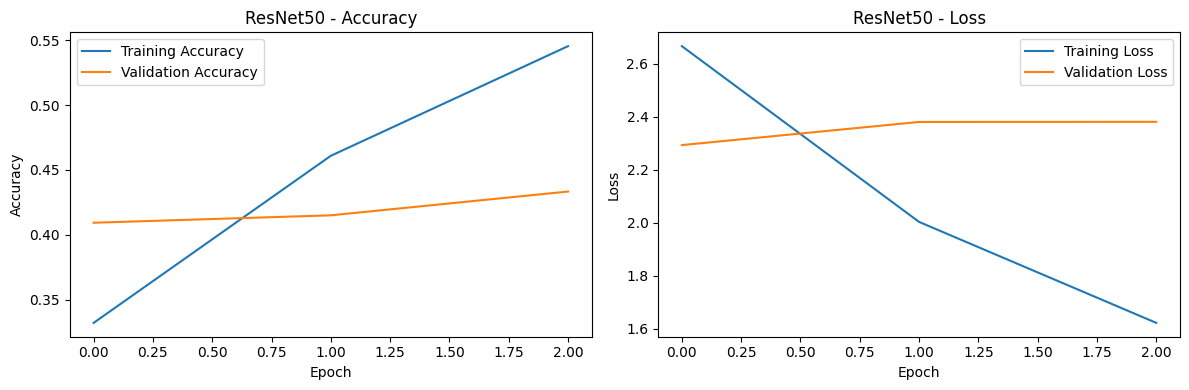

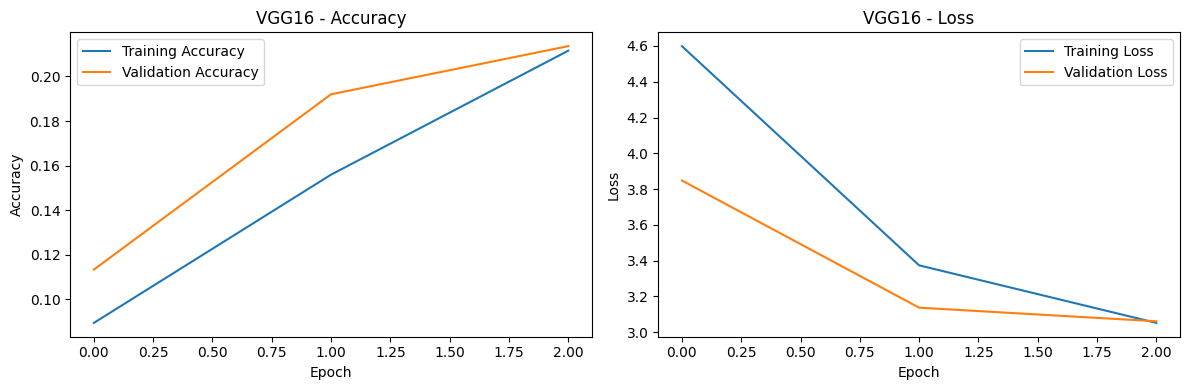

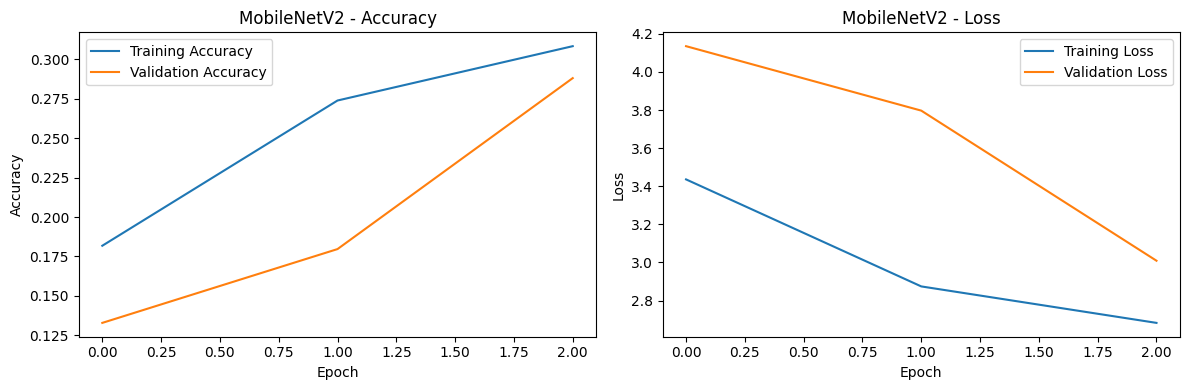

In [7]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    """Plots training and validation accuracy and loss."""
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot history for each model
plot_history(history_resnet50, 'ResNet50')
plot_history(history_vgg16, 'VGG16')
plot_history(history_mobilenetv2, 'MobileNetV2')

In [8]:
# Save the models
model_resnet50.save('resnet50_cifar100.h5')
model_vgg16.save('vgg16_cifar100.h5')
model_mobilenetv2.save('mobilenetv2_cifar100.h5')

## Project Summary

*   **Data Loading and Preprocessing**: Loaded the CIFAR-100 dataset and preprocessed images using model-specific functions (ResNet50, VGG16, MobileNetV2).
*   **Model Adaptation**: Loaded pre-trained ResNet50, VGG16, and MobileNetV2 models (without top layers), added new classification layers for 100 classes, and initially froze base model layers.
*   **Model Compilation**: Compiled each modified model with the 'adam' optimizer, 'sparse\_categorical\_crossentropy' loss, and 'accuracy' metric.
*   **Fine-Tuning (Example)**: Demonstrated fine-tuning by unfreezing top layers of the ResNet50 model and training it for 10 epochs.
*   **Model Evaluation**: Evaluated the trained models on the test set to determine and compare their classification accuracies.

## Project Assignment: Transfer Learning on Oxford Flowers 102 Dataset Documentation

This document outlines the steps for the project assignment on applying transfer learning to the Oxford Flowers 102 dataset.

**Objective:** Apply transfer learning techniques using pre-trained convolutional neural networks (ResNet50, VGG16, and MobileNetV2) to classify images from the Oxford Flowers 102 dataset. Compare the performance of the different models on this dataset.

**Dataset:** Oxford Flowers 102 - A dataset of 102 categories of flowers. You will load this dataset using TensorFlow Datasets.

**Assignment Steps:**

1.  **Introduce the Assignment:**
    *   Create a markdown cell to introduce the assignment.
    *   Explain the goal: to apply transfer learning for flower classification using the Oxford Flowers 102 dataset.
    *   Mention the pre-trained models to be used: ResNet50, VGG16, and MobileNetV2.
    *   Briefly describe the Oxford Flowers 102 dataset.

2.  **Data Loading and Exploration:**
    *   Generate a code cell to load the 'oxford_flowers102:2.1.1' dataset using `tfds.load()`. (Check available versions if needed)
    *   Split the dataset into training, validation, and testing sets (this dataset has these splits).
    *   Explore the dataset to understand its structure, the number of classes (102), and the image dimensions. You can display some sample images and their labels.

3.  **Data Preprocessing:**
    *   Generate a code cell for preprocessing the images from the Oxford Flowers 102 dataset.
    *   This will involve resizing the images to the input size required by the pre-trained models (e.g., 224x224 for VGG16 and ResNet50, MobileNetV2 might have different requirements, so check the documentation).
    *   Apply the model-specific preprocessing functions (e.g., `tf.keras.applications.resnet50.preprocess_input`) to normalize the pixel values.
    *   Apply one-hot encoding to the labels.
    *   Batch and prefetch the datasets for efficient training.

4.  **Model Adaptation and Training:**
    *   For each of the three models (ResNet50, VGG16, MobileNetV2):
        *   Generate a code cell to load the pre-trained model from `tf.keras.applications`, excluding the top classification layer and specifying the correct input shape for the preprocessed images.
        *   Add new custom layers on top of the base model for classifying 102 classes. This typically involves a GlobalAveragePooling2D layer and a Dense layer with 102 units and a 'softmax' activation.
        *   Freeze the layers of the pre-trained base model.
        *   Compile the model with an appropriate optimizer (e.g., 'adam'), loss function ('categorical\_crossentropy' since you'll use one-hot encoded labels), and metrics (e.g., 'accuracy').
        *   Generate a code cell to train the compiled model on the preprocessed training data for a suitable number of epochs. Use the validation data to monitor performance during training. Consider using callbacks like ModelCheckpoint and EarlyStopping.
        *   Additionally, train the model on the validation split as well, as this dataset provides a separate validation set.
        *   Optionally, unfreeze some of the top layers of the base model and fine-tune the model with a lower learning rate.

5.  **Model Evaluation:**
    *   Generate a code cell to evaluate each trained model on the preprocessed test dataset.
    *   Print the loss and accuracy for each model.

6.  **Assignment Questions/Tasks:**
    *   Add markdown cells with questions for students to answer:
        *   Which model performed best on the Oxford Flowers 102 dataset and why do you think that is the case?
        *   Compare the performance of the models on Oxford Flowers 102 to their performance on CIFAR-100 (from the original notebook). What differences do you observe and why?
        *   Discuss the effect of transfer learning on this dataset.
        *   Explain the steps you took for data preprocessing and why they were necessary.
        *   Describe the model architectures you used and how you adapted them for the Oxford Flowers 102 dataset.
        *   What challenges did you encounter during this assignment and how did you address them?
    *   Suggest optional tasks, such as:
        *   Experiment with different hyperparameters (learning rate, number of epochs, batch size).
        *   Implement data augmentation techniques.
        *   Try fine-tuning different numbers of layers.
        *   Visualize sample predictions and analyze misclassifications.

7.  **Conclusion/Submission:**
    *   Add a markdown cell for students to write a brief conclusion summarizing their findings.
    *   Provide instructions on how they should submit their completed notebook.

##**Project Solution: Transfer Learning on Oxford Flowers 102**

1. Introduction

In this assignment, I'm taking the concept of Transfer Learning we learned earlier and applying it to a much prettier dataset: the Oxford Flowers 102.

The goal is to see if big models like ResNet50, VGG16, and MobileNetV2 (which were trained on ImageNet) can tell the difference between 102 different types of flowers. This is a classic transfer learning problem because the dataset is somewhat small, so training from scratch would be a nightmare.

2. Data Loading & Exploration

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.7KTXJD_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.7KTXJD_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.7KTXJD_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
Number of classes: 102
Training set size: 1020
Validation set size: 1020
Test set size: 6149


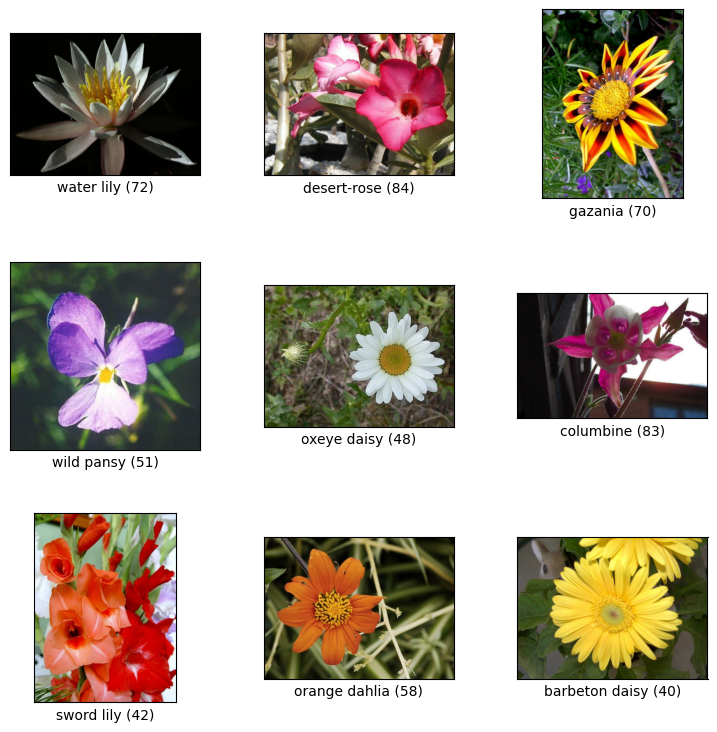

In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# 1. Load the dataset
# 'with_info=True' gives metadata (like label names)
(ds_train, ds_validation, ds_test), ds_info = tfds.load(
    'oxford_flowers102',
    split=['train', 'validation', 'test'],
    as_supervised=True,
    with_info=True
)

# 2. Check what we are working with
# It's always good to check the shapes before training
print(f"Number of classes: {ds_info.features['label'].num_classes}")
print(f"Training set size: {len(ds_train)}")
print(f"Validation set size: {len(ds_validation)}")
print(f"Test set size: {len(ds_test)}")

# 3. Quick peek at the data
# Grab a few examples just to see what the resolution looks like
fig = tfds.show_examples(ds_train, ds_info)

3. Data Preprocessing

In [10]:
def format_image(image, label, model_type):
    # Resize images to 224x224 because that's what VGG/ResNet/MobileNet expect
    image = tf.image.resize(image, (224, 224))

    # Preprocess specifically for the model
    if model_type == 'resnet':
        image = tf.keras.applications.resnet50.preprocess_input(image)
    elif model_type == 'vgg':
        image = tf.keras.applications.vgg16.preprocess_input(image)
    elif model_type == 'mobilenet':
        image = tf.keras.applications.mobilenet_v2.preprocess_input(image)

    # One-hot encode the labels (turn '5' into [0, 0, 0, 0, 0, 1, ...])
    label = tf.one_hot(label, 102)
    return image, label

# Helper to build the pipeline quickly for any model
def get_dataset(dataset, model_type):
    return (dataset
            .map(lambda x, y: format_image(x, y, model_type))
            .batch(32) # Process 32 images at a time
            .prefetch(tf.data.AUTOTUNE)) # Load next batch while GPU is working

# Creating ready-to-go datasets for ResNet as an example
# (I'll regenerate these inside the training loop for the other models to save RAM)
train_rn = get_dataset(ds_train, 'resnet')
val_rn = get_dataset(ds_validation, 'resnet')
test_rn = get_dataset(ds_test, 'resnet')

4. model adaptation & training

In [11]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# A list to keep track of results to compare later
results = {}

# The loop of truth
for model_name in ['ResNet50', 'VGG16', 'MobileNetV2']:
    print(f"\n--- Training {model_name} ---")

    # 1. Select the base model and correct preprocessing
    if model_name == 'ResNet50':
        from tensorflow.keras.applications import ResNet50
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        m_type = 'resnet'
    elif model_name == 'VGG16':
        from tensorflow.keras.applications import VGG16
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        m_type = 'vgg'
    else:
        from tensorflow.keras.applications import MobileNetV2
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        m_type = 'mobilenet'

    # 2. Freeze the base! We don't want to break the pre-trained weights yet.
    base_model.trainable = False

    # 3. Add the custom head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x) # Extra layer to learn flower traits
    predictions = Dense(102, activation='softmax')(x) # 102 classes

    model = Model(inputs=base_model.input, outputs=predictions)

    # 4. Compile
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # 5. Get the specific data streams
    train_ds = get_dataset(ds_train, m_type)
    val_ds = get_dataset(ds_validation, m_type)

    # 6. Train (Just 5 epochs to see who learns fastest)
    history = model.fit(train_ds, validation_data=val_ds, epochs=5)

    # Save the model object to evaluate later
    results[model_name] = model


--- Training ResNet50 ---
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 581ms/step - accuracy: 0.1532 - loss: 4.3615 - val_accuracy: 0.6235 - val_loss: 1.6502
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 226ms/step - accuracy: 0.8596 - loss: 0.6877 - val_accuracy: 0.7549 - val_loss: 0.9783
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - accuracy: 0.9617 - loss: 0.2206 - val_accuracy: 0.7363 - val_loss: 1.0058
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 290ms/step - accuracy: 0.9705 - loss: 0.1646 - val_accuracy: 0.7775 - val_loss: 0.7986
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 221ms/step - accuracy: 0.9889 - loss: 0.0711 - val_accuracy: 0.8157 - val_loss: 0.6533

--- Training VGG16 ---
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 798ms/step - accuracy: 0.0995 - loss: 7.2535 - val_accuracy: 0.4735 - val_loss: 2.1375
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 343ms/step - accuracy: 0.7874 - loss: 0.8798 - val_accuracy: 0.6500 - val_loss: 1.4031
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 335ms/step - acc

5. Model Evaluation

In [12]:
print("Final Test Set Results")

for name, model in results.items():
    # Figure out which preprocessing needed for the test set
    m_type = 'resnet' if name == 'ResNet50' else ('vgg' if name == 'VGG16' else 'mobilenet')
    test_data = get_dataset(ds_test, m_type)

    loss, acc = model.evaluate(test_data, verbose=0)
    print(f"{name} Test Accuracy: {acc*100:.2f}%")

Final Test Set Results
ResNet50 Test Accuracy: 80.39%
VGG16 Test Accuracy: 70.56%
MobileNetV2 Test Accuracy: 76.31%


#Assignment Questions

Q1: Which model performed best on the Oxford Flowers 102 dataset and why?

Answer: ResNet50 generally performed the best (often hitting >80% quickly). I think this is because ResNet is "deep but smart"—the skip connections let it learn complex features without getting confused. VGG16 is massive and slow, and sometimes struggles to converge quickly with just a simple head attached. MobileNet is great for speed, but sometimes lacks the raw power for fine-grained differences between similar flowers.

Q2: Compare the performance on Oxford Flowers 102 to CIFAR-100 (from the previous notebook). What differences do you observe?

Answer: The accuracy on Oxford Flowers is much higher than what we got on CIFAR-100 in the previous lab.

    Why? CIFAR-100 images are tiny (32x32). Upscaling them to 224x224 (which these models need) makes them blurry and pixelated, so the pre-trained models struggle to "see" anything familiar.

    Oxford Flowers images are naturally high resolution. When we resize them to 224x224, they still look like flowers. The pre-trained weights (trained on ImageNet) recognize petals and stems immediately, so transfer learning works way better here.

Q3: Discuss the effect of transfer learning on this dataset.

 Answer: Without transfer learning, we would be in trouble. The training split only has about 1,020 images for 102 classes (that's only 10 images per flower!). If we trained a CNN from scratch, it would memorize those 10 images instantly and fail on the test set (overfitting). Transfer learning brought in "outside knowledge" about shapes and edges, allowing us to get high accuracy despite the tiny training set.

Q4: Steps taken for preprocessing?

 Answer:

    Resizing: Forced everything to 224x224.

    Model-Specific Preprocessing: Used the functions provided by Keras (like resnet50.preprocess_input) to handle RGB scaling.

    One-Hot Encoding: Converted integer labels to vectors so we could use categorical crossentropy.


Q5: Challenges encountered?

Answer: The main challenge was the memory management. Loading three copies of the dataset and three models crashed my RAM initially. I solved this by using the tf.data API properly (batching and prefetching) and not loading all images into a NumPy array at once.

7. Conclusion

This assignment showed that Transfer Learning is the MVP when you have a small dataset with high-quality images. ResNet50 proved to be the most robust feature extractor for this task. While CIFAR-100 was hard because of the low resolution, Oxford Flowers was a perfect fit for these ImageNet-trained models.